In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


# Install FastText

In [3]:
!git clone https://github.com/facebookresearch/fastText.git

Cloning into 'fastText'...
remote: Enumerating objects: 3531, done.
remote: Total 3531 (delta 0), reused 0 (delta 0), pack-reused 3531
Receiving objects: 100% (3531/3531), 8.02 MiB | 29.74 MiB/s, done.
Resolving deltas: 100% (2225/2225), done.


In [4]:
cd fastText/

/content/fastText


In [5]:
!pip install .

Processing /content/fastText
  Created wheel for fasttext: filename=fasttext-0.9.1-cp36-cp36m-linux_x86_64.whl size=2831179 sha256=23e9c8ed3f3e23de0b444c0b02de996042d01eb0ff78d78cf2291003b342eb59
  Stored in directory: /tmp/pip-ephem-wheel-cache-hdl4hguc/wheels/a1/9f/52/696ce6c5c46325e840c76614ee5051458c0df10306987e7443
Successfully built fasttext


# Combine english and hindi dictionary

In [0]:
def load_embedding_dict(embedding_path, embedding_size, embedding_format):
    """
    Load emb dict from file, or load pre trained binary fasttext model.
    Args:
        embedding_path: path to the vec file, or binary model
        embedding_size: int, embedding_size
        embedding_format: 'bin' or 'vec'

    Returns: Embeddings dict, or fasttext pre trained model

    """
    print("Loading word embeddings from {}...".format(embedding_path))
    count = 0
    count_t = 0
    if embedding_format == 'vec':
        default_embedding = np.zeros(embedding_size)
        embedding_dict = collections.defaultdict(lambda: default_embedding)
        skip_first = embedding_format == "vec"
        with open(embedding_path) as f:
            
            for i, line in enumerate(f.readlines()):
                if skip_first and i == 0:
                    continue
                splits = line.split()
                # print(len(splits),i)
                if (len(splits) == embedding_size + 1):
                    count_t = count_t+1
                    word = splits[0]
                    embedding = np.array([float(s) for s in splits[1:]])
                    embedding_dict[word] = embedding
                else:
                    count = count+1
    elif embedding_format == 'bin':
        embedding_dict = fasttext.load_model(embedding_path)
    else:
        raise ValueError('Not supported embeddings format {}'.format(embedding_format))
    print("Done loading word embeddings.")
    print(count_t,count)
    return embedding_dict 

In [0]:
import collections

In [8]:
hi_dictionary = load_embedding_dict("/content/gdrive/My Drive/minor_project2/Copy of wiki.hi.align.vec", embedding_size = 300, embedding_format = "vec")

Loading word embeddings from /content/gdrive/My Drive/minor_project2/Copy of wiki.hi.align.vec...
Done loading word embeddings.
157993 23


In [9]:
en_dictionary = load_embedding_dict("/content/gdrive/My Drive/minor_project2/Copy of wiki.en.align.vec", embedding_size = 300, embedding_format = "vec")

Loading word embeddings from /content/gdrive/My Drive/minor_project2/Copy of wiki.en.align.vec...
Done loading word embeddings.
2519178 192


In [0]:
z = {**hi_dictionary, **en_dictionary}

# Load Datasets

## Hindi

In [0]:
data = pd.read_csv('/content/gdrive/My Drive/minor_project2/csv files/label_Partho - label_Partho.csv')
data2 = pd.read_csv('/content/gdrive/My Drive/minor_project2/csv files/label_Adarsh - label_Adarsh.csv')
data3 = pd.read_csv('/content/gdrive/My Drive/minor_project2/csv files/label_Keshav - label_Keshav.csv')
data4 = pd.read_csv('/content/gdrive/My Drive/minor_project2/csv files/label_Gaurav - label_Gaurav.csv')

In [0]:
df1 = data.dropna(subset=['location1'])
df2 = data2.dropna(subset=['location1'])
df3 = data3.dropna(subset=['location1'])
df4 = data4.dropna(subset=['location1'])
combined_df = pd.concat([df1, df2, df3, df4], sort=False)

In [0]:
combined_df = combined_df[['id','text','location1','location2','location3','location4','location5']]

combined_df

tweet = list(combined_df['text'])
location1 = list(combined_df['location1'])
location2 = list(combined_df['location2'])
location3 = list(combined_df['location3'])
location4 = list(combined_df['location4'])
location5 = list(combined_df['location5'])

## English

In [0]:
data_eng = pd.read_csv("/content/gdrive/My Drive/minor_project2/model/Eq_Lab3000.csv")

In [0]:
data_eng = data_eng[['tweets','labels']]

In [0]:
data_eng = data_eng.dropna(subset=['labels'])

In [0]:
data_eng = data_eng[data_eng['labels'] != '0']

In [18]:
data_eng

,tweets,labels
1,earthquake m km ssw of gambell alaska mins ago...,6 7
3,rt tremblement de terre mag km de jiangzikeng ...,8
4,rt and on the th anniversary of the earthquake...,11
5,rt and now we re reaching the present moment i...,16
8,rt massive magnitude earthquake hits taipei,6
...,...,...
2994,rt earthquake m alaska peninsula mins ago jan ...,4 5
2996,annelizebester rt laco f twenty four years ago...,14
2997,earthquake in san francisco bitcoin s dear god...,3 4 9 10
2999,here s what the office looked like after the n...,10


In [0]:
tweet_eng = list(data_eng['tweets'])
labels = list(data_eng['labels'])

# Preprocess Tweets

## Hindi

In [0]:
import string,re

In [0]:
def preprocess_tweet(text):

#     # Check characters to see if they are in punctuation
#     nopunc = [char for char in text if char not in string.punctuation]
#     # Join the characters again to form the string.
#     nopunc = ''.join(nopunc)
    # convert text to lower-case
#     nopunc = nopunc.lower()
    # remove URLs
    nopunc = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', text)
    nopunc = re.sub(r'http\S+', '', nopunc)
    # remove usernames
    nopunc = re.sub('@[^\s]+', '', nopunc)
    
    nopunc = re.sub(r'([\'\"\.\(\)\!\?\-\\\/\,])', r' ', nopunc)
    nopunc = re.sub(r'([\;\:\|•«\n])', ' ', nopunc)
    # remove the # in #hashtag
#     nopunc = re.sub(r'#([^\s]+)', r'\1', nopunc)
    nopunc = re.sub(r'#\w*','',nopunc)
    # remove repeated characters
#     nopunc = word_tokenize(nopunc)
    # remove stopwords from final word list
#     return [word for word in nopunc if word not in stopwords.words('english')]
    try:
        nopunc = re.sub(u'([\U00002600-\U000027BF])|([\U0001f300-\U0001f64F])|([\U0001f680-\U0001f6FF])', '',nopunc)
    except re.error:
        nopunc = re.sub(u'([\u2600-\u27BF])|([\uD83C][\uDF00-\uDFFF])|([\uD83D][\uDC00-\uDE4F])|([\uD83D][\uDE80-\uDEFF])', '', nopunc)
    nopunc = [char for char in nopunc if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return nopunc

In [0]:
for i in range(0,len(tweet)):
    tweet[i] = preprocess_tweet(tweet[i])

In [0]:
all_locations = []
for i in range(0, len(location1)):
    temp = []
    if type(location1[i]) == str:
        temp.append(location1[i])
    if type(location2[i]) == str:
        temp.append(location2[i])
    if type(location3[i]) == str:
        temp.append(location3[i])
    if type(location4[i]) == str:
        temp.append(location4[i])
    if type(location5[i]) == str:
        temp.append(location5[i])
    all_locations.append(temp)

In [0]:
all_locations_sep = []
for i in range(0,len(all_locations)):
    t = []
    for j in range(0,len(all_locations[i])):
        xx = all_locations[i][j].split()
        for k in range(0, len(xx)):
            t.append(xx[k])
    all_locations_sep.append(t)

## English

In [0]:
def preprocess_tweet(text):

#     # Check characters to see if they are in punctuation
#     nopunc = [char for char in text if char not in string.punctuation]
#     # Join the characters again to form the string.
#     nopunc = ''.join(nopunc)
    # convert text to lower-case
#     nopunc = nopunc.lower()
    # remove URLs
    nopunc = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', text)
    nopunc = re.sub(r'http\S+', '', nopunc)
    # remove usernames
    nopunc = re.sub('@[^\s]+', '', nopunc)
    
    nopunc = re.sub(r'([\'\"\.\(\)\!\?\-\\\/\,])', r' ', nopunc)
    nopunc = re.sub(r'([\;\:\|•«\n])', ' ', nopunc)
    # remove the # in #hashtag
#     nopunc = re.sub(r'#([^\s]+)', r'\1', nopunc)
    nopunc = re.sub(r'#\w*','',nopunc)
    # remove repeated characters
#     nopunc = word_tokenize(nopunc)
    # remove stopwords from final word list
#     return [word for word in nopunc if word not in stopwords.words('english')]
    try:
        nopunc = re.sub(u'([\U00002600-\U000027BF])|([\U0001f300-\U0001f64F])|([\U0001f680-\U0001f6FF])', '',nopunc)
    except re.error:
        nopunc = re.sub(u'([\u2600-\u27BF])|([\uD83C][\uDF00-\uDFFF])|([\uD83D][\uDC00-\uDE4F])|([\uD83D][\uDE80-\uDEFF])', '', nopunc)
    nopunc = [char for char in nopunc if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return nopunc

In [0]:
for i in range(0,len(tweet_eng)):
    tweet_eng[i] = preprocess_tweet(tweet_eng[i])

In [0]:
all_locations_sep_eng = []
for i in range(0,len(labels)):
    # print(i)
    t = []
    xx = labels[i].split()
    for k in range(0, len(xx)):
            t.append(int((xx[k]))-1)
    all_locations_sep_eng.append(t)

# Tokenizer common function for both 

In [0]:
import string, re, sys, codecs

In [0]:
# from indicnlp.common import IndicNlpException

### tokenizer patterns 
triv_tokenizer_indic_pat=re.compile(r'(['+string.punctuation+r'\u0964\u0965'+r'])')
triv_tokenizer_urdu_pat=re.compile(r'(['+string.punctuation+r'\u0609\u060A\u060C\u061E\u066A\u066B\u066C\u066D\u06D4'+r'])')

## date, numbers, section/article numbering
pat_num_seq=re.compile(r'([0-9]+ [,.:/] )+[0-9]+')

def trivial_tokenize_indic(s): 
    """
    A trivial tokenizer which just tokenizes on the punctuation boundaries. This also includes punctuations for the Indian language scripts
      - the purna virama and the deergha virama
    returns a list of tokens   
    """
    tok_str=triv_tokenizer_indic_pat.sub(r' \1 ',s.replace('\t',' '))
#     return re.sub(r'[ ]+',' ',tok_str).strip(' ').split(' ')

    s=re.sub(r'[ ]+',' ',tok_str).strip(' ')
    
    # do not tokenize numbers and dates
    new_s=''
    prev=0
    for m in pat_num_seq.finditer(s):
        start=m.start()
        end=m.end()
        if start>prev:
            new_s=new_s+s[prev:start]
            new_s=new_s+s[start:end].replace(' ','')
            prev=end
   
    new_s=new_s+s[prev:]
    s=new_s
    
    return s.split(' ')

def trivial_tokenize_urdu(s): 
    """
    A trivial tokenizer which just tokenizes on the punctuation boundaries. This also includes punctuations for the Urdu script.
    These punctuations characters were identified from the Unicode database for Arabic script by looking for punctuation symbols.
    returns a list of tokens   
    """
    tok_str=triv_tokenizer_urdu_pat.sub(r' \1 ',s.replace('\t',' '))
    return re.sub(r'[ ]+',' ',tok_str).strip(' ').split(' ')

def trivial_tokenize(s,lang='hi'): 
    """
    Trivial tokenizer for languages in the Indian sub-continent
    """
    if lang=='ur':
        return trivial_tokenize_urdu(s)
    else:
        return trivial_tokenize_indic(s)

# One Hot Encode

## Hindi

In [0]:
def boolean_vec(tweet):
    import math
    one_hot_encoded=[]
    for i in range(0,len(tweet)):
        tText = tweet[i]
        splits = trivial_tokenize(tText)
        temp = [0]*len(splits)
        for x in range(0,len(splits)):
            for l in all_locations_sep[i]:
                if l==splits[x]:
                    temp[x] = 1
#             if l1==x or l1 in x:
#                 temp.append(1)
#             if type(l2)==str and (l2==x or l2 in x):
#                 temp.append(1)
#             if type(l3)==str and (l3==x or l3 in x):
#                 temp.append(1)
#             if type(l4)==str and (l4==x or l4 in x):
#                 temp.append(1)
#             if type(l5)==str and (l5==x or l5 in x):
#                 temp.append(1)
#             else:
#                 temp.append(0)
        one_hot_encoded.append(temp)
        temp=[]
    return one_hot_encoded

In [0]:
one_hot_encoded = boolean_vec(tweet)

In [32]:
maxlen = 0
for i in range(0,len(one_hot_encoded)):
    maxlen = max(len(one_hot_encoded[i]),maxlen)
print(maxlen)

72


In [0]:
MAX_SEQUENCE_LENGTH = maxlen #72

In [0]:
for i in range(0,len(one_hot_encoded)):
    pad_len = MAX_SEQUENCE_LENGTH - len(one_hot_encoded[i])
    for j in range(0,pad_len):
        one_hot_encoded[i].append(0)

In [0]:
for i in range(0,len(one_hot_encoded)):
    if(len(one_hot_encoded[i]) != MAX_SEQUENCE_LENGTH):
        print("Not encoded")

## English

In [0]:
def boolean_vec_eng(tweet):
    import math
    one_hot_encoded=[]
    for i in range(0,len(tweet)):
        tText = tweet[i]
        splits = trivial_tokenize(tText)
        temp = [0]*len(splits)
        bound = list(range(0,len(splits)))
        # for x in range(0,len(splits)):
        for l in all_locations_sep_eng[i]:
            if l in bound:
                temp[l] = 1
#             if l1==x or l1 in x:
#                 temp.append(1)
#             if type(l2)==str and (l2==x or l2 in x):
#                 temp.append(1)
#             if type(l3)==str and (l3==x or l3 in x):
#                 temp.append(1)
#             if type(l4)==str and (l4==x or l4 in x):
#                 temp.append(1)
#             if type(l5)==str and (l5==x or l5 in x):
#                 temp.append(1)
#             else:
#                 temp.append(0)
        one_hot_encoded.append(temp)
        temp=[]
    return one_hot_encoded

In [0]:
one_hot_encoded_eng = boolean_vec_eng(tweet_eng)

In [38]:
maxlen_eng = 0
for i in range(0,len(one_hot_encoded_eng)):
    maxlen_eng = max(len(one_hot_encoded_eng[i]),maxlen_eng)
print(maxlen_eng)

55


In [0]:
for i in range(0,len(one_hot_encoded_eng)):
    pad_len = MAX_SEQUENCE_LENGTH - len(one_hot_encoded_eng[i])
    for j in range(0,pad_len):
        one_hot_encoded_eng[i].append(0)

In [0]:
for i in range(0,len(one_hot_encoded_eng)):
    if(len(one_hot_encoded_eng[i]) != MAX_SEQUENCE_LENGTH):
        print("Not encoded")

# Embedding word vectors

In [41]:
print(len(combined_df),len(tweet),len(one_hot_encoded))
print(len(data_eng),len(tweet_eng),len(one_hot_encoded_eng))

1942 1942 1942
1903 1903 1903


In [0]:
window_length = 72
n_features = 300

In [0]:
def get_word_vector(word):
    embedding_vector = z.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        return embedding_vector

In [0]:
def text_to_vector(text):
    
    words = trivial_tokenize(text)

    window = words[:window_length]
    
    x = np.zeros((window_length, n_features))

    for i, word in enumerate(window):
        if get_word_vector(word) is not None:
            x[i, :] = get_word_vector(word).astype('float32')

    return x

In [0]:
def df_to_data(df,tw):
    
    x = np.zeros((len(df), window_length, n_features), dtype='float32')

    for i, comment in enumerate(tw):
        x[i, :] = text_to_vector(comment)

    return x

In [0]:
X_data_hi = df_to_data(combined_df,tweet)
X_data_en = df_to_data(data_eng,tweet_eng)

In [47]:
print(X_data_hi.shape)
print(X_data_en.shape)

(1942, 72, 300)
(1903, 72, 300)


In [0]:
X_data = np.concatenate((X_data_hi, X_data_en), axis=0)

In [49]:
X_data.shape

(3845, 72, 300)

In [50]:
from keras.utils import to_categorical
y_hi = [to_categorical(i, num_classes=2) for i in one_hot_encoded]

from keras.utils import to_categorical
y_en = [to_categorical(i, num_classes=2) for i in one_hot_encoded_eng]

y_hi = np.asarray(y_hi)
y_en = np.asarray(y_en)

y_data = np.concatenate((y_hi,y_en),axis=0)

print(y_data.shape)

(3845, 72, 2)


# Train Test Split

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [52]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(3076, 72, 300) (769, 72, 300) (3076, 72, 2) (769, 72, 2)


# Model Bi-LSTM

## Training

In [0]:
from keras.models import Model, load_model
from keras.layers import Dense, Input, Dropout, GRU, Activation, Bidirectional, LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras import backend as K
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [54]:
input_i = Input(shape=(72,300,),dtype='float32')
X = Bidirectional(LSTM(512,return_sequences=True))(input_i)
X = Bidirectional(LSTM(256,return_sequences=True))(X)
X = Bidirectional(LSTM(128,return_sequences=True))(X)
X = Dropout(0.5)(X)
# X = Dense(2, activation='sigmoid')(X)
X = TimeDistributed(Dense(2, activation="softmax"))(X)
model = Model(input_i, X)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [55]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 72, 300)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 72, 1024)          3330048   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 72, 512)           2623488   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 72, 256)           656384    
_________________________________________________________________
dropout_1 (Dropout)          (None, 72, 256)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 72, 2)             514       
Total params: 6,610,434
Trainable params: 6,610,434
Non-trainable params: 0
_________________________________________________

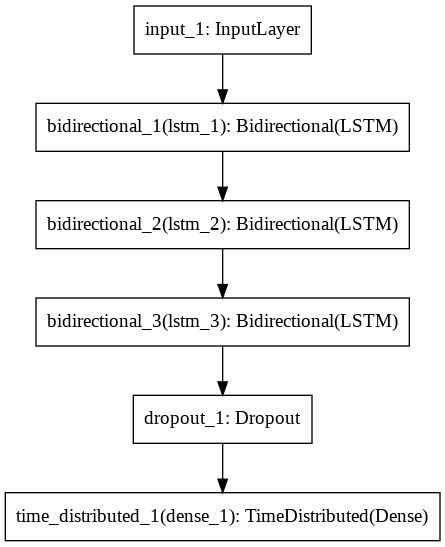

In [56]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

from PIL import Image
Image.open("model.png")

In [57]:
model.compile(loss='binary_crossentropy', optimizer='adam',metrics = ["accuracy"])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
filepath="/content/gdrive/My Drive/minor_project2/weightsEngHinMIX_all30.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [61]:
history = model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs = 10,batch_size=32,callbacks=callbacks_list)

Train on 3076 samples, validate on 769 samples
Epoch 1/10
3076/3076 [==============================] - 237s 77ms/step - loss: 0.0596 - acc: 0.9800 - val_loss: 0.0381 - val_acc: 0.9871

Epoch 00001: val_loss improved from inf to 0.03812, saving model to /content/gdrive/My Drive/minor_project2/weightsEngHinMIX_all30.best.hdf5
Epoch 2/10
3076/3076 [==============================] - 232s 76ms/step - loss: 0.0351 - acc: 0.9884 - val_loss: 0.0296 - val_acc: 0.9898

Epoch 00002: val_loss improved from 0.03812 to 0.02959, saving model to /content/gdrive/My Drive/minor_project2/weightsEngHinMIX_all30.best.hdf5
Epoch 3/10
3076/3076 [==============================] - 237s 77ms/step - loss: 0.0264 - acc: 0.9913 - val_loss: 0.0270 - val_acc: 0.9907

Epoch 00003: val_loss improved from 0.02959 to 0.02700, saving model to /content/gdrive/My Drive/minor_project2/weightsEngHinMIX_all30.best.hdf5
Epoch 4/10
3076/3076 [==============================] - 236s 77ms/step - loss: 0.0241 - acc: 0.9919 - val_lo

In [0]:
model.load_weights('/content/gdrive/My Drive/minor_project2/weightsEngHinMIX_all30.best.hdf5')

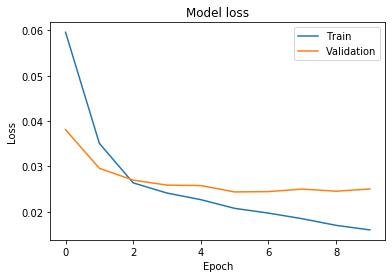

In [63]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Testing

In [0]:
p = model.predict(np.array(X_test))

In [65]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, 2).ravel(), np.argmax(p, axis=2).ravel(),labels=[0,1], target_names=["other","disaster place"]))

                precision    recall  f1-score   support

         other       0.99      1.00      1.00     53960
disaster place       0.86      0.80      0.83      1408

      accuracy                           0.99     55368
     macro avg       0.93      0.90      0.91     55368
  weighted avg       0.99      0.99      0.99     55368



# Model CNN

## Training

In [0]:
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Input, Dropout, GRU, Activation, Bidirectional, LSTM, Conv2D, Flatten, Conv1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras import backend as K
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [0]:
input_i = Input(shape=(72,300),dtype='float32')
X = Conv1D(512, kernel_size=1, activation='relu', input_shape=(72,300))(input_i)
X = Conv1D(256, kernel_size=1, activation='relu')(X)
X = Conv1D(128, kernel_size=1, activation='relu')(X)
X = Dropout(0.5)(X)
# X = Flatten()(X)
# X = Dense(903168, activation='softmax')(X)
X = Dense(2, activation="softmax")(X)
model2 = Model(input_i, X)

In [68]:
model2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 72, 300)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 72, 512)           154112    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 72, 256)           131328    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 72, 128)           32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 72, 128)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 72, 2)             258       
Total params: 318,594
Trainable params: 318,594
Non-trainable params: 0
_____________________________________________________

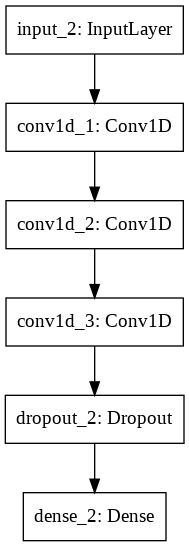

In [70]:
from keras.utils import plot_model
plot_model(model2, to_file='modelCNN.png')

from PIL import Image
Image.open("modelCNN.png")

In [0]:
model2.compile(loss='binary_crossentropy', optimizer='adam',metrics = ["accuracy"])

In [0]:
filepath="/content/gdrive/My Drive/minor_project2/weightsEngHinMIXcnn_all30_CNN.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [0]:
import warnings

In [74]:
history = model2.fit(X_train, y_train,validation_data=(X_test, y_test), epochs = 10,batch_size=32,callbacks=callbacks_list)

Train on 3076 samples, validate on 769 samples
Epoch 1/10
3076/3076 [==============================] - 7s 2ms/step - loss: 0.1168 - acc: 0.9766 - val_loss: 0.0356 - val_acc: 0.9885

Epoch 00001: val_loss improved from inf to 0.03560, saving model to /content/gdrive/My Drive/minor_project2/weightsEngHinMIXcnn_all30_CNN.best.hdf5
Epoch 2/10
3076/3076 [==============================] - 6s 2ms/step - loss: 0.0314 - acc: 0.9914 - val_loss: 0.0312 - val_acc: 0.9912

Epoch 00002: val_loss improved from 0.03560 to 0.03122, saving model to /content/gdrive/My Drive/minor_project2/weightsEngHinMIXcnn_all30_CNN.best.hdf5
Epoch 3/10
3076/3076 [==============================] - 6s 2ms/step - loss: 0.0283 - acc: 0.9924 - val_loss: 0.0293 - val_acc: 0.9917

Epoch 00003: val_loss improved from 0.03122 to 0.02935, saving model to /content/gdrive/My Drive/minor_project2/weightsEngHinMIXcnn_all30_CNN.best.hdf5
Epoch 4/10
3076/3076 [==============================] - 6s 2ms/step - loss: 0.0266 - acc: 0.9927

In [0]:
model2.load_weights(filepath)

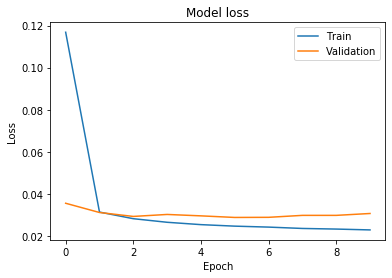

In [77]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Testing

In [0]:
p = model2.predict(np.array(X_test))

In [80]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, 2).ravel(), np.argmax(p, axis=2).ravel(),labels=[0,1], target_names=["other","disaster place"]))

                precision    recall  f1-score   support

         other       1.00      1.00      1.00     53960
disaster place       0.85      0.82      0.84      1408

      accuracy                           0.99     55368
     macro avg       0.92      0.91      0.92     55368
  weighted avg       0.99      0.99      0.99     55368

